## Notebook demonstrating how to use MONDA to access So-Rad above-water radiometry data 

MONDA (MONocle data analysis) is a suite of tools for retrieving, quality-checking, plotting, and saving data from sensors developed during the MONOCLE project: https://pypi.org/project/monda/


The So-Rad (Solar-tracking Radiometry) platform is one of the sensor systems accessed via MONDA. So-Rad consists of a downwelling irradiance sensor (Ed), a sky radiance sensor (Ls or Lsky), and a water radiance sensor (Lt), which are automatically processed to derive remote-sensing reflectance (Rrs). A key feature of So-Rad is that the radiance sensors rotate to maintain an optimal viewing geometry, mitigating for sun glint and platform shading.  https://www.monocle-h2020.eu/Sensors_and_platforms/Solar_tracking_radiometry_platform_en

 


 This notebook is designed for end-users of So-Rad data. It demonstrates how to: 
- 1.  Retrieve pre-processed So-Rad Rrs and (ir)radiance spectra from PML Geoserver using WFS standard
- 2.  Apply a set of quality control filters
- 3.  Plot data illustrating quality control, data coverage, and reflectance spectra.
- 4.  Save results

Sections 1 - 4 use a single day for demonstration purposes. At the end of the notebook is an example where data is extracted for multiple days (Section 5).

In [1]:
# Imports of python modules
import sys
import os

#from monda.sorad import access, plots, qc  # This will be used for import once issue is fixed #
# Note `qc' import does not work via monda (also issues in ADIAS).

# For spring 2024 changes, I have used a local import of qc, plots and access as a temporary work-around
sys.path.append('/users/rsg/tjor/Sorad_mondademos/MONDA/src/monda/sorad')  
import qc 
import plots
import access

import datetime
import logging
import numpy as np
import pandas as pd
import argparse
from math import ceil

## 1.  Retrieve pre-processed So-Rad Rrs and (ir)radiance spectra from PML Geoserver using WFS standard

Monda uses the following user-defined fields to retrieve So-Rad data

- platform_id:  the serial number of a So-Rad platform
- start_time:   date/time to start collecting data from
- end_time:     date/time to start collecting data from
- bbox:         bounding box corner coordinates (lat,lon,lat,lon)
- target:        destination folder for plots/data
- rrsalgorithm:   choice of fingerprint (fp) or 3c Rrs processing algorithm. 3c used as default


Data from multiple So-Rad systems available on the WFS Geoserver. A data dashboard, which summarises aquistion dates and locations is provided here: https://rsg.pml.ac.uk/dashboards/d/JUzLKd9nz/monocle-so-rad?orgId=1




In [2]:
# Sets So-Rad platform ID. As of May 2024, data from the following systems are available: PML_SR001, PML_SR002, 
# PML_SR003, PML_SR004, PML_SR005, PML_SR007, PML_SR009, PML_SR0012.
platform_id = 'PML_SR001' 

# PML_SR001 is typically deployed on PML's research vessel Quest between Spring-Autumn each year. Data is available since 2021.
# The deployment dates for PML_SR001 data are:
    # 2024:  10/04/2024 -
    # 2023:  12/06/2023 - 10/10/2023
    # 2022:  23/04/2022 - 08/16/2022
    # 2021:  25/04/2021 - 13/04/2021  

In [3]:
# Set start and end datetimes for data query -  a single date is used for demonstration purposes
start_time =   datetime.datetime.strptime('2023-10-10', '%Y-%m-%d')
end_time   =   datetime.datetime.strptime('2023-10-11', '%Y-%m-%d')


In [4]:
# Set choice of rrs processing algorithm. So-Rad data is processed using either the Fingerprint (FP) algorithm, Simis and Olsson 
# 2013, Remote Sensing of Environment, or 3C, Groetsch et al. 2017, Optics Express. 3C uses the parameterisation in
# Jordan et. al 2022. Remote Sensing. 

#Each algorithm has its' own quality control chain. This notebook uses 3C as a default.
# Paper links: https://www.sciencedirect.com/science/article/pii/S0034425713001223, 
# https://opg.optica.org/oe/fulltext.cfm?uri=oe-25-16-A742&id=368913 ,
# https://www.mdpi.com/2072-4292/14/10/2491.

rrsalgorithm = '3c' # other option `fp' (fingerprint)
if rrsalgorithm == 'fp':
    layer = 'rsg:sorad_public_view_fp_full'
elif rrsalgorithm == '3c':
    layer = 'rsg:sorad_public_view_3c_full'
else:
    log.error(f"{rrsalgorithm} is not a valid choice and must be one of [fp, 3c]")
wl_output = np.arange(350, 900, 1)  # output range to interpolate (ir)radiance spectra. 
# Note that Rrs is already interpolated to 1-nm over the available sensor range.


In [5]:
# Set other parameters needed to retrieve data
bbox = None # An optional bounding box is specified providing four space-separated coordinates (corner 1 lat lon corner 2 lat lon).
target = '../tests/your_data_folder' # folder to save data. If no folder is given, then data is saved in working directory 

In [6]:
# This function retrieves So-Rad Rrs data from that has already been processed using the 3c method
response = access.get_wfs(platform = platform_id,
                          timewindow = (start_time, end_time),
                          layer='rsg:sorad_public_view_3c_full',
                          bbox=None)

# The retreived fields (including metadata, input (ir)radiance spectra, output Rrs spectra, and optimzation parameters 
#from 3c are listed below:
print(response['result'][0].keys()) 

2024-05-14 09:29:33,591 | sorad-downloader | INFO | Pre-paging request: https://rsg.pml.ac.uk/geoserver/rsg/wfs?request=GetFeature&version=2.0.0&service=WFS&typeName=rsg:sorad_public_view_3c_full&count=1000&srsname=EPSG:4326&outputFormat=json&sortBy=time+A&CQL_FILTER=time%20between%202023-10-10T00%3A00%3A00%20AND%202023-10-11T00%3A00%3A00%20AND%20platform_id%3D%27PML_SR001%27&resultType=hits
2024-05-14 09:29:33,975 | sorad-downloader | INFO | 319 features matched
2024-05-14 09:29:35,669 | sorad-downloader | INFO | Page 0, starting at count 0: 319 features
dict_keys(['id', 'time', 'platform_id', 'sample_uuid', 'platform_uuid', 'gps_speed', 'rel_view_az', 'tilt_avg', 'tilt_std', 'license', 'c3_rmsd', 'c3_resid', 'c3_delta', 'c3_rho_s', 'c3_rho_dd', 'c3_rho_ds', 'c3_alpha', 'c3_beta', 'c3_updated', 'c3_wl_grid', 'c3_rrs', 'lt_wl', 'lt_spectrum', 'ls_wl', 'ls_spectrum', 'ed_wl', 'ed_spectrum', 'lon', 'lat'])


The retrieved fields can be grouped as:

- (ir)radiance data: 'ed_spectrum', 'ed_wl', 'ls_spectrum', 'ls_wl', 'lt_spectrum', 'lt_wl'
Ed is downwelling irradiance, Ls is sky radiance, Lt is total water (upwelling) radiance. There are wavelength vectors for each spectra

- reflectance data and 3c optimiaation output: 'c3_rrs', 'c3_wl_grid', 'c3_alpha', 'c3_beta', 'c3_delta', 'c3_resid', 'c3_rho_dd', 'c3_rho_ds', 'c3_rho_s', 'c3_rmsd', , 'c3_updated','c3_rrs'
rrs is c3_wlgrid

- Metadata: 'id', 'lat', 'license', 'lon', 'platform_id', 'platform_uuid', 'rel_view_az', 'sample_uuid', 'tilt_avg', 'tilt_std', 'time'.




In [7]:
# extracts data in np.array formats.
rrswl, time, lat, lon, rel_view_az,\
       ed, ls, lt, rrs,\
       sample_uuids, platform_ids, platform_uuids,\
       gps_speeds, tilt_avgs, tilt_stds = access.unpack_response(response, rrsalgorithm, wl_output)


## 2. Apply a set of Quality Control filters

The quality control and plot functions within MONDA are designed to operate on daily data chunks. Here we provide a worked example for a single day of data. At the end of this notebook we provide code so that multiple days can be extracted, quality-controlled, and saved.

The quality control is applied sequentially in 4 levels:
- Step (0) QC filters based on relative azimuth and tilt/tilt std
- Step (ii) Level 1 radiometric quality control filters (i.e. QC applied to radiance or irradiance spectra)
- Step (ii) Level 2 quality control filters specific to 3c optimization 
- Step (iii) Level 2 quality control filters that apply to reflectance spectrum.

The output to each quality control function is a binary mask (1 = QC pass, 0 == QC fail). There are multiple sub-flags for each step, which are grouped together following a logical OR gate for QC failures.

Individual quality control functions are documented here:
https://github.com/monocle-h2020/MONDA/blob/master/src/monda/sorad/qc.py

#### Step (0): QC filters based on relative azimuth and tilt/tilt std

In [8]:
# Note; in this example the tilt sensor was not functioning properly
q_az =  qc.rel_az_filter(rel_view_az, lower_azi_bound = 110, upper_azi_bound = 170)
q_tilt, q_tilt_std =  qc.tilt_filter(tilt_avgs, tilt_stds, upper_tilt_bound=5, upper_tilt_std_bound = np.sqrt(3))
q_0 =  qc.combined_filter(q_az , qc.combined_filter(q_tilt, q_tilt_std))


Tilt sensor was stuck on single value: do not apply tilt filter


In [9]:
# This is an example of an individual QC flag mask which tests if the relative viewing azimuth is in specified range. 
# So-Rad is programmed to maintain a relative viewing azimuth close to +/- 135 degrees, but during ship manoeuvres, 
# or unfavourable ship orientations, the relative azimuth can be outside a desired tolerance from 135 degrees.

print("Relative viewing azimuth (azimuth of radiance sensors with respect to solar azimuth( = " +  str(rel_view_az))
print("QC for relative viewing azimuth = "  + str(q_az))


Relative viewing azimuth (azimuth of radiance sensors with respect to solar azimuth( = [ 136.71636927  134.75473024  134.40751057  132.94892124  133.08938301
  138.0670821   133.82139824  134.40375974  135.66696773  134.47065321
  132.77049615  137.21827455  135.95339809  134.60856197  135.99946865
  139.95990822  134.52747041  133.62630115  132.28082182  135.27010762
  133.2908529   135.26302633  133.34461525  136.5437986   135.12523762
  135.74436274  137.27443805  134.31297552  134.29579668  136.78570056
  135.01541625  134.34076979  135.0470525   134.49928196  134.52427233
  136.46434172  133.5765356   133.97044027  132.99958396  134.83962667
  133.05782289  136.57632356  134.64070054  135.20326822  136.30801056
  135.62308734  133.27691945  134.32821695  133.23130056  134.64696607
  135.19775349  134.4977336   135.12305518  138.20536596  133.67143943
  134.18412293  135.30553727  138.16443688  134.45155936  135.79720555
  131.6074132   136.76985787  133.44769843  136.15912948  134

### Step (i): Radiometric quality control filters (QC applied to radiance or irradiance spectra)

In [10]:

q_lt_ed = qc.qc_lt_ed_filter(ed, lt, time, wl_output, threshold = 0.025) # Lt/Ed ratio (glint) filtering
q_ed =    qc.qc_ed_filter(ed, min_ed_threshold = 500) # filters on =Rd and Ls anomalies
q_ls =    qc.qc_ls_filter(ls, wl_output, threshold = 1)
q_1 =     qc.combined_filter(qc.combined_filter(qc.combined_filter(q_lt_ed, q_ed), q_ls), q_0) # combined step 0 and step 1 mask

In [11]:
# This is an example of an individual QC flag mask, which tests if the irradiance (Ed) spectral maximum is above a certain threshold
# Light levels were relatively low for above-water radiometry (it was an overcast day in October),
print('QC binary mask for irradiance threshold = ' + str(q_ed))

QC binary mask for irradiance threshold = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 1.

In [12]:
# This is the q_1 mask (which combines all negative flags at step (0) and step (i) using an OR gate).
print('QC mask at end of step (i) = ' + str(q_1))

QC mask at end of step (i) = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 0.]

#### Step (ii): QC filters specfic to 3C optimisation output 

In [13]:
if rrsalgorithm == '3c':
    rmsd_3c =     np.array([response['result'][i]['c3_rmsd'] for i in range(len(response['result']))]) # rmsd values used in 3C residual filter
    rho_ds =      np.array([response['result'][i]['c3_rho_ds'] for i in range(len(response['result']))]) # rho factors
    rho_dd =      np.array([response['result'][i]['c3_rho_dd'] for i in range(len(response['result']))])
    rho_s =       np.array([response['result'][i]['c3_rho_s'] for i in range(len(response['result']))])
    q_rho =       qc.qc_3c_rho_filter(rho_ds, rho_dd, rho_s, upperbound = 0.1) # removes data where rho terminates at optimization bounds
    q_1_resid = qc.qc_3cresidual(q_1, rmsd_3c, tol = 1.5) # removes data where residual parameter is above threshold standard-deivation multiple
    q_2 =    qc.combined_filter(q_rho, q_1_resid) # combined step 0, step 1 and step 2 mask


#### Step (iii): addtional QC filters that apply to Rrs spectrum

In [14]:
q_ss =        qc.qc_SS_NIR_filter(rrswl, rrs, upperthreshold = 3, lowerthreshold = 0.5)  # similarity spectrum filter
q_maxrange =  qc.qc_rrs_maxrange(rrs, upperthreshold = 0.1, lowerthreshold = 0.00)  # filters on max and min Rrs
q_min =       qc.qc_rrs_min(rrs, rrswl)

# Optional filters
# q_coastal = qc_coastalwater_rrsfilter(rrs, wl) #  filter based on expected shape of rrs - example from Warren 2019 used. users can input their own spectra here (will depend on water type)
# q_var = qc_radiometric_variability(ed, lt, ls, time, wl, windowlength = 60, var_threshold =1.1, var_metric = 'zscore_max')

if rrsalgorithm == '3c': # recommended rrs qc mask for 3C method (combines steps (0), (i), (ii) and (iii))
    q_3 = qc.combined_filter(q_2, qc.combined_filter(q_min, (qc.combined_filter(q_ss, q_maxrange))))
elif rrsalgorithm == 'fp': # recommended rrs qc mask for fp method (combines steps (i) and (iii) QC)
    q_3 = qc.combined_filter(q_1, qc.combined_filter(q_min, (qc.combined_filter(q_ss, q_maxrange)))) 

## 3. Plot data 

<Figure size 640x480 with 0 Axes>

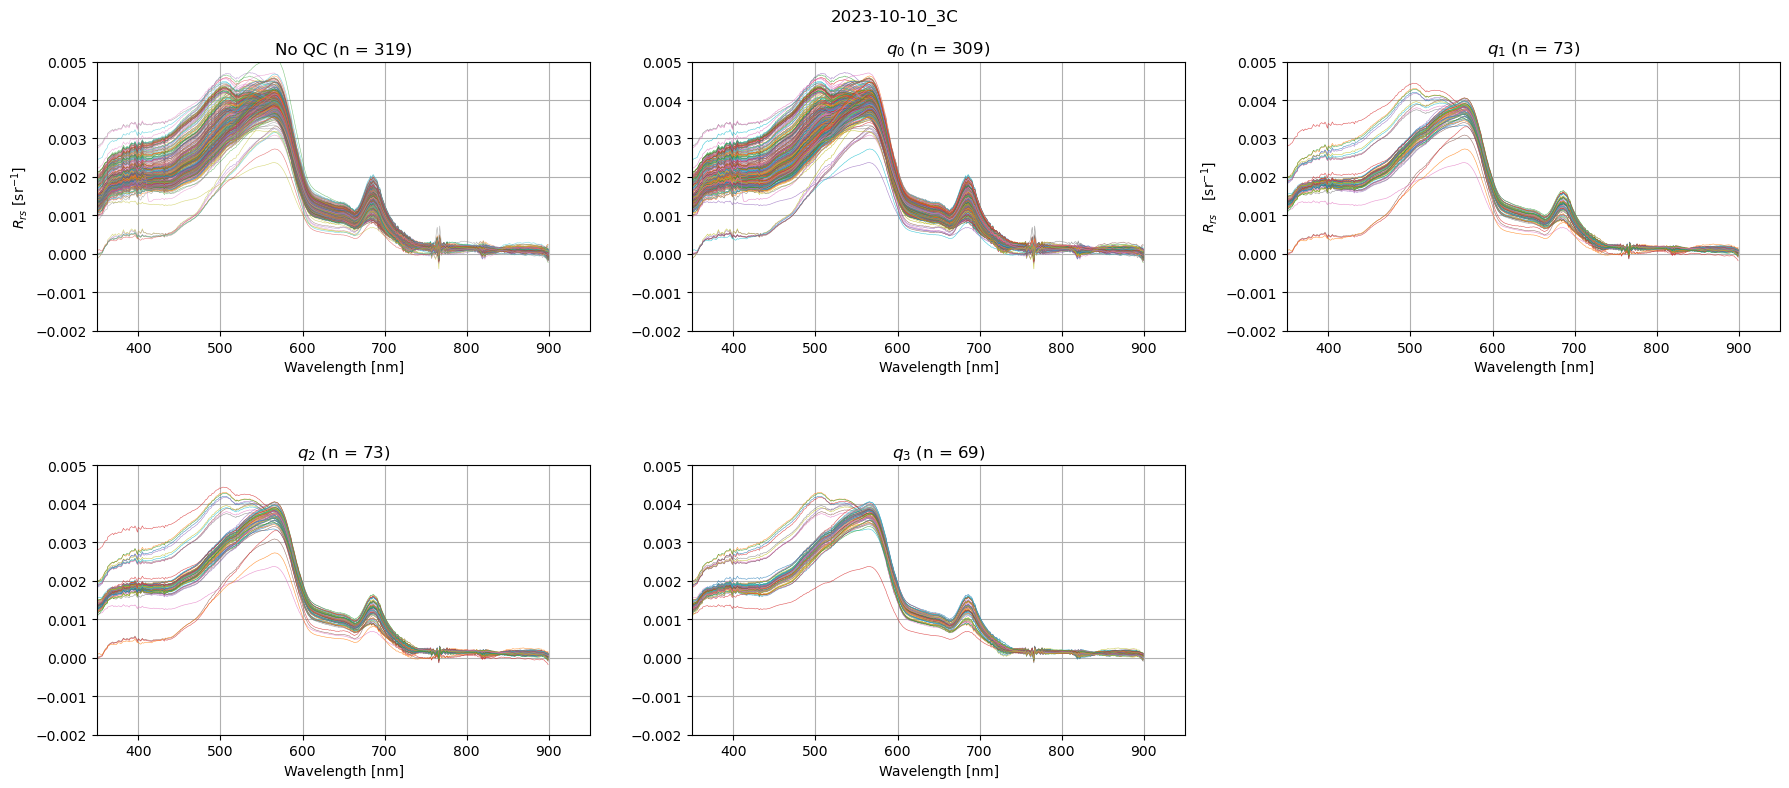

In [15]:
file_id = f"{start_time.strftime('%Y-%m-%d')}_{rrsalgorithm.upper()}"   # l
if rrsalgorithm == '3c':
    # This figure illustrates sequentially how data is removed for the different QC masks
    plots.plot_rrs_qc_3c(rrs, time, rrswl, q_0, q_1, q_2, q_3, file_id, target)



2024-05-14 09:29:39,386 | matplotlib.legend | WARNING | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


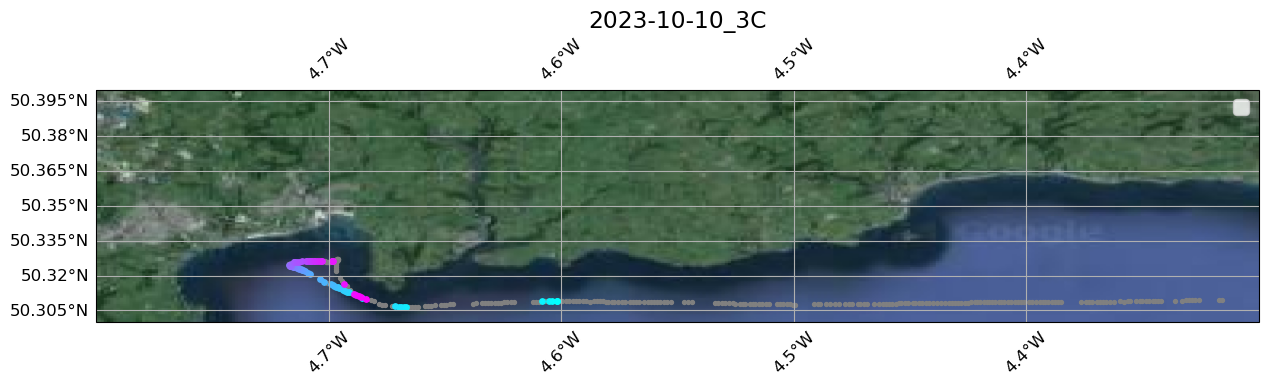

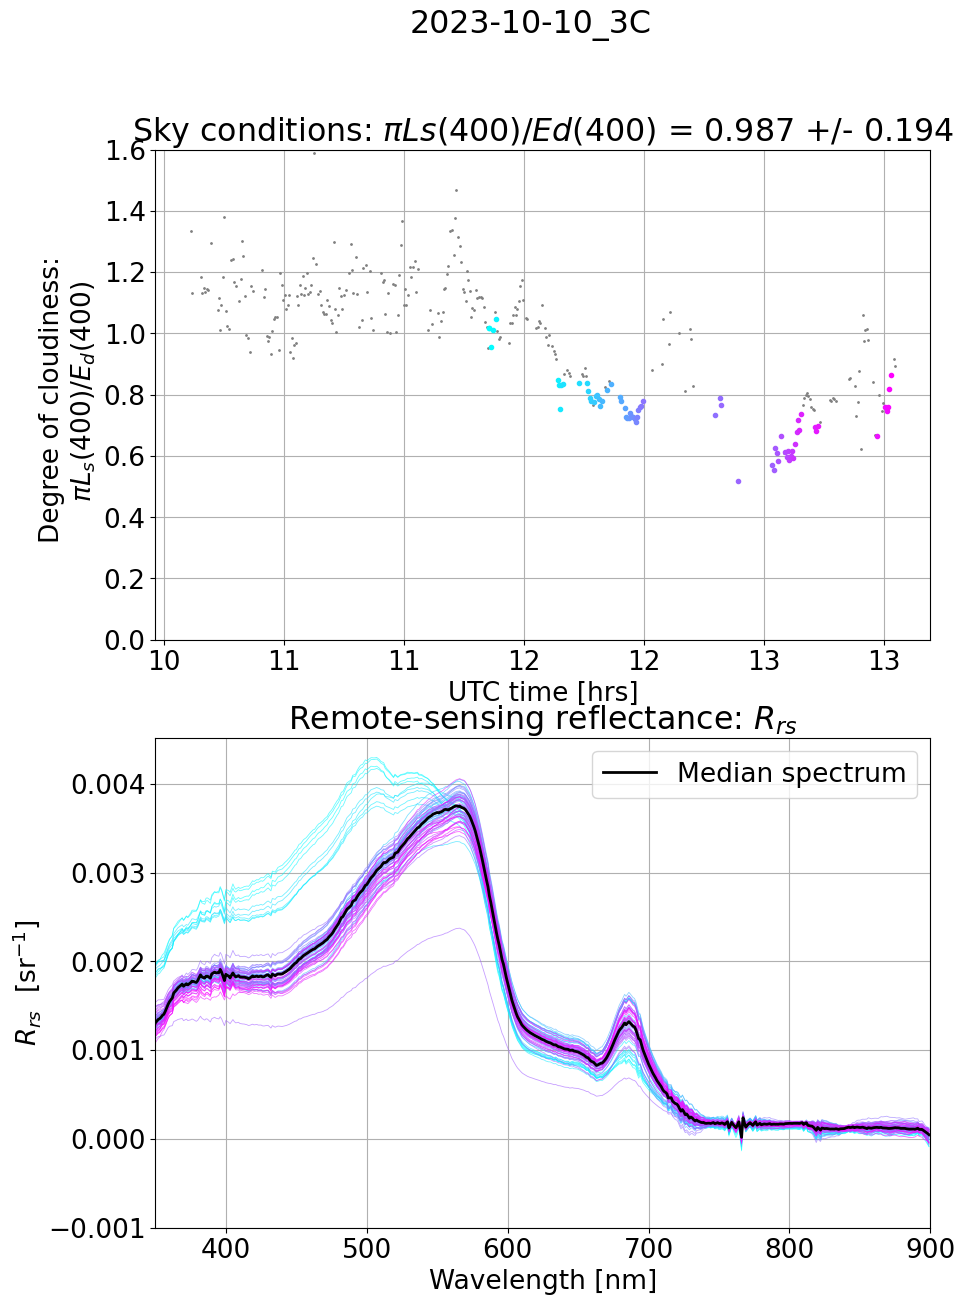

In [16]:
# Theses figures illustrate coverage maps and Rrs results for data that has been quality-controlled. The upper panel in results figure shows
# a time series for a cloudiness proxy (values ~ 1 are overcast, and values ~ 0.3 are clear skies). See Simis and Olson 2013 for more details.
if rrsalgorithm == '3c':
    plots.plot_coveragemap(lat, lon, q_3, file_id, target, map_resolution = 11)
    plots.plot_results(ed, ls, wl_output, rrs, rrswl, time, q_3, file_id, target)

In [17]:
# these are fingerprint-variants of the plot functions 
if rrsalgorithm == 'fp':
    plots.plot_rrs_qc_fp(rrs, time, rrswl, q_1, q_3, file_id, target)
    plots.plot_coveragemap(lat, lon, q_3, file_id, target, map_resolution = 11)
    plots.plot_results(ed, ls, wl_output, rrs, rrswl, time, q_3, file_id, target)


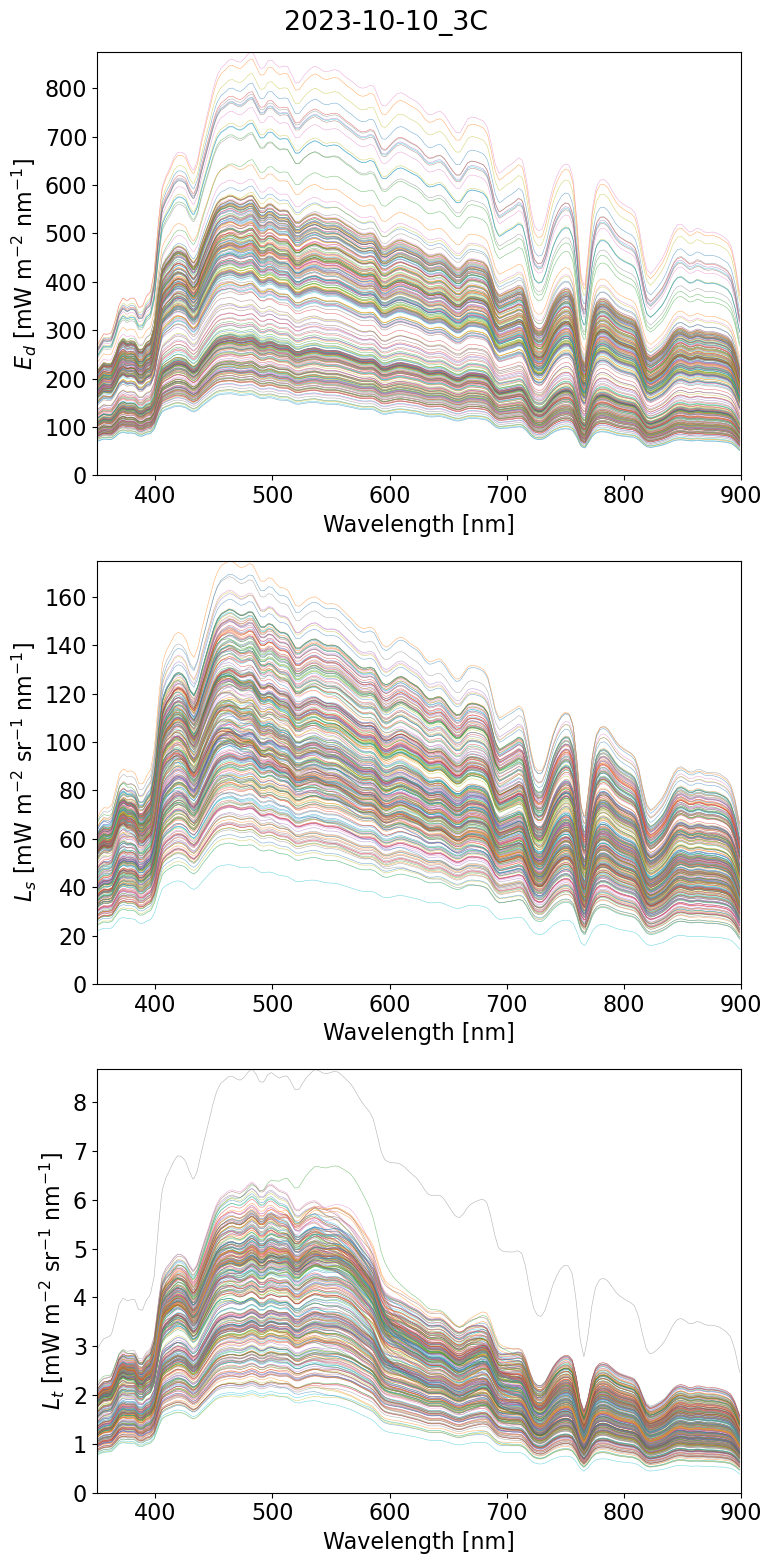

In [18]:
# Output irradiance spectra - this figure are a summary of the individual (ir)radiance spectra that were collected 
file_id = f"{start_time.strftime('%Y-%m-%d')}_{rrsalgorithm.upper()}"   
plots.plot_ed_ls_lt(ed, ls, lt, time, wl_output, file_id, target)


## 4. Save results

In [19]:
# save meta data in csv format
d = pd.DataFrame()   # store core metadata and qc flags in a data frame for easy output formatting
d['sample_uuid'] = sample_uuids
d['platform_id'] = platform_ids
d['platform_uuid'] = platform_uuids
d['timestamp'] = time
d['lat'] = lat
d['lon'] = lon
d['gps_speed'] = gps_speeds
d['tilt_avg'] = tilt_avgs
d['tilt_std'] = tilt_stds
d['rel_view_az '] = rel_view_az
d['q_0'] = q_0     # Mask after step (0) QC
d['q_1'] = q_1     # Mask after step (i) QC

if rrsalgorithm == 'fp':
    d['q_3'] = q_3 # Mask after step (iii) QC: currently recommended for FP rrs data analysis

elif rrsalgorithm == '3c':
    d['q_2'] = q_2   # Mask after step (ii) QC (only applies to 3C)
    d['q_3'] = q_3  # Mask after step (iii) QC: currently recommended for 3C  rrs data analysis

d_filename = os.path.join(target, file_id + '_metadata.csv')
d.to_csv(d_filename)

In [20]:
# save Rrs, Ed, Lt, Ls in csv format. The rows are timestamps and the columns are the timestamps.
# The number of rows match the number of rows in each metadata file,
r_filename = os.path.join(target, file_id + '_Rrs.csv')
np.savetxt(r_filename, rrs, delimiter=',',  header = ",".join([str(w) for w in rrswl]), fmt='%.8f')

header = ",".join([str(w) for w in wl_output])
ls_filename = os.path.join(target, file_id + '_Ls.csv')
lt_filename = os.path.join(target, file_id + '_Lt.csv')
ed_filename = os.path.join(target, file_id + '_Ed.csv')
np.savetxt(ls_filename, ls, delimiter=',', header = header, fmt='%.8f')
np.savetxt(lt_filename, lt, delimiter=',', header = header, fmt='%.8f')
np.savetxt(ed_filename, ed, delimiter=',', header = header, fmt='%.8f')

## 5. Extracting mutiple days

This section shows how to ouput multiple days at once. This section of notebook code is based on: https://github.com/monocle-h2020/MONDA/tree/master/src/monda/tests

In [21]:
# These are input fields to retreive data as before. We now select the whole of July 2023 
platform_id = 'PML_SR001' 

start_time =   datetime.datetime.strptime('2023-7-1', '%Y-%m-%d')
end_time   =   datetime.datetime.strptime('2023-8-1', '%Y-%m-%d')

rrsalgorithm = '3c' 
wl_output = np.arange(350, 900, 1)  

bbox = None 
target = '../tests/your_data_folder' 

In [22]:
# These are logical variales to output daily plots and data files
output_plots = False # logical for saving figures

output_radiance = True # logical for saving files
output_metadata = True
output_rrs = True


In [23]:
# This is the code-section which outputs over multiple days. The QC chain is the same as step 3

log = logging.getLogger('sorad-test')
myFormat = '%(asctime)s | %(name)s | %(levelname)s | %(message)s'
formatter = logging.Formatter(myFormat)
logging.basicConfig(level = 'INFO', format = myFormat, stream = sys.stdout)

# split the request into days
initial_day = start_time.date()
final_day = end_time.date()
assert final_day >= initial_day

# split the request into discrete days
days = (final_day - initial_day).days + 1
log.info(f"Request spans {days} day(s)")

for i in range(days):
    this_day      = initial_day + datetime.timedelta(days = i)
    datetime_i    = datetime.datetime(this_day.year, this_day.month, this_day.day, 0, 0, 0)
    datetime_e    = datetime.datetime(this_day.year, this_day.month, this_day.day, 23, 59, 59, 999999)

    if datetime_i < start_time:
        datetime_i = start_time
    if datetime_e > end_time:
        datetime_e = end_time

    log.info(f"Request timeframe {datetime_i.isoformat()} - {datetime_e.isoformat()}")

    response = access.get_wfs(platform = platform_id,
                              timewindow = (datetime_i, datetime_e),
                              layer=layer, bbox=bbox)

    log.info(f"{response['length']} features received.")

    if response['length'] == 0:
        continue

    file_id = f"{datetime_i.strftime('%Y-%m-%d')}_{rrsalgorithm.upper()}"   # labelling for output data files and plots

    rrswl, time, lat, lon, rel_view_az,\
           ed, ls, lt, rrs,\
           sample_uuids, platform_ids, platform_uuids,\
           gps_speeds, tilt_avgs, tilt_stds = access.unpack_response(response, rrsalgorithm, wl_output)

    if output_plots:
        log.info("Creating (ir)radiance plots")
        plots.plot_ed_ls_lt(ed, ls, lt, time, wl_output, file_id, target)

    # Step (0) QC filters based on relative aziumuth and tilt/tilt std
    q_az =  qc.rel_az_filter(rel_view_az, lower_azi_bound = 110, upper_azi_bound = 170)
    q_tilt, q_tilt_std =  qc.tilt_filter(tilt_avgs, tilt_stds, upper_tilt_bound=5, upper_tilt_std_bound = np.sqrt(3))
    q_0 =  qc.combined_filter(q_az , qc.combined_filter(q_tilt, q_tilt_std))

    # Step (i) radiometric quality control filters (i.e. QC applied to l or e spectra)
    q_lt_ed = qc.qc_lt_ed_filter(ed, lt, time, wl_output, threshold = 0.020) # lt/Ed ratio (glint) filtering
    q_ed =    qc.qc_ed_filter(ed, min_ed_threshold = 500) # filters on ed and ls anomalies
    q_ls =    qc.qc_ls_filter(ls, wl_output, threshold = 1)
    q_1 =     qc.combined_filter(qc.combined_filter(qc.combined_filter(q_lt_ed, q_ed), q_ls), q_0) # combined `radiometric' qc mask - inlcludes data passing step(0)

    # Step (ii): (3c) algorithmic qc filters specfic to 3C (rmsd or termination at rho bounds)
    if rrsalgorithm == '3c':
        rmsd_3c =     np.array([response['result'][i]['c3_rmsd'] for i in range(len(response['result']))]) # rmsd values used in 3C residual filter
        rho_ds =      np.array([response['result'][i]['c3_rho_ds'] for i in range(len(response['result']))]) # rho factors
        rho_dd =      np.array([response['result'][i]['c3_rho_dd'] for i in range(len(response['result']))])
        rho_s =       np.array([response['result'][i]['c3_rho_s'] for i in range(len(response['result']))])
        q_rho =       qc.qc_3c_rho_filter(rho_ds, rho_dd, rho_s, upperbound = 0.1) # removes data where rho terminates at optimization bounds
        q_1_resid = qc.qc_3cresidual(q_1, rmsd_3c, tol = 1.5) # removes data where residual parameter is above threshold standard-deivation multiple
        q_2 =    qc.combined_filter(q_rho, q_1_resid)

    # Step (iii):  addtional qc metrics that apply to Rrs spectrum
    q_ss =        qc.qc_SS_NIR_filter(rrswl, rrs, upperthreshold = 3, lowerthreshold = 0.5)  # similarity spectrum filter
    q_maxrange =  qc.qc_rrs_maxrange(rrs, upperthreshold = 0.1, lowerthreshold = 0.00)    # filters on max and min rrs
    q_min =       qc.qc_rrs_min(rrs, rrswl)
    
    # Optional filters
    # q_coastal = qc_coastalwater_rrsfilter(rrs, wl) #  filter based on expected shape of rrs - example from Warren 2019 used. users can input their own spectra here (will depend on water type)
    # q_var = qc_radiometric_variability(ed, lt, ls, time, wl, windowlength = 60, var_threshold =1.1, var_metric = 'zscore_max')

    if rrsalgorithm == '3c':
        q_3 = qc.combined_filter(q_2, qc.combined_filter(q_min, (qc.combined_filter(q_ss, q_maxrange)))) # recommended rrs qc mask for 3C method (combines step (i), (ii) and (iii) QC)
    elif rrsalgorithm == 'fp':
        q_3 = qc.combined_filter(q_1,    qc.combined_filter(q_min, (qc.combined_filter(q_ss, q_maxrange)))) # recommended rrs qc mask for FP method (combines step (i) and (iii) QC)

    if output_plots and rrsalgorithm == 'fp':
        log.info("Creating Rrs plots")
        plots.plot_rrs_qc_fp(rrs, time, rrswl, q_1, q_3, file_id, target)
        plots.plot_coveragemap(lat, lon, q_3, file_id, target, map_resolution = 11)
        plots.plot_results(ed, ls, wl_output, rrs, rrswl, time, q_3, file_id, target)

    elif output_plots and rrsalgorithm == '3c':
        log.info("Creating Rrs plots")
        plots.plot_rrs_qc_3c(rrs, time, rrswl, q_0, q_1, q_2, q_3, file_id, target)
        plots.plot_coveragemap(lat, lon, q_3, file_id, target, map_resolution = 11)
        plots.plot_results(ed, ls, wl_output, rrs, rrswl, time, q_3, file_id, target)

    d = pd.DataFrame()   # store core metadata and qc flags in a data frame for easy output formatting
    d['sample_uuid'] = sample_uuids
    d['platform_id'] = platform_ids
    d['platform_uuid'] = platform_uuids
    d['timestamp'] = time
    d['lat'] = lat
    d['lon'] = lon
    d['gps_speed'] = gps_speeds
    d['tilt_avg'] = tilt_avgs
    d['tilt_std'] = tilt_stds
    d['rel_view_az '] = rel_view_az
    d['q_0'] = q_0     # Mask after step (0) QC
    d['q_1'] = q_1     # Mask after step (i) QC

    if rrsalgorithm == 'fp':
        d['q_3'] = q_3 # Mask after step (iii) QC: currently recommended for FP rrs data analysis

    elif rrsalgorithm == '3c':
        d['q_2'] = q_2   # Mask after step (ii) QC (only applies to 3C)
        d['q_3'] = q_3  # Mask after step (iii) QC: currently recommended for 3C  rrs data analysis

    # optional to output all qc masks
    # q_keys = [i for i in locals() if i.startswith('q_')]
    # for i in range(len(q_keys)): # add all qc fields to the dataframe
    #     d[str(q_keys[i])] = pd.Series(eval(q_keys[i]))

    # Store outputs
    if output_metadata:
        d_filename = os.path.join(target, file_id + '_metadata.csv')
        if os.path.exists(d_filename):
            log.warning(f"File {d_filename} was overwritten")
        d.to_csv(d_filename)

    if output_rrs:
        r_filename = os.path.join(target, file_id + '_Rrs.csv')
        if os.path.exists(r_filename):
            log.warning(f"File {r_filename} was overwritten")
        np.savetxt(r_filename, rrs, delimiter=',',  header = ",".join([str(w) for w in rrswl]), fmt='%.8f')

    if output_radiance:
        header = ",".join([str(w) for w in wl_output])
        ls_filename = os.path.join(target, file_id + '_Ls.csv')
        lt_filename = os.path.join(target, file_id + '_Lt.csv')
        ed_filename = os.path.join(target, file_id + '_Ed.csv')
        if os.path.exists(ls_filename):
            log.warning(f"File {ls_filename} was overwritten")
        if os.path.exists(lt_filename):
            log.warning(f"File {lt_filename} was overwritten")
        if os.path.exists(ed_filename):
            log.warning(f"File {ed_filename} was overwritten")
        np.savetxt(ls_filename, ls, delimiter=',', header = header, fmt='%.8f')
        np.savetxt(lt_filename, lt, delimiter=',', header = header, fmt='%.8f')
        np.savetxt(ed_filename, ed, delimiter=',', header = header, fmt='%.8f')

2024-05-14 09:29:47,405 | sorad-test | INFO | Request spans 32 day(s)
2024-05-14 09:29:47,407 | sorad-test | INFO | Request timeframe 2023-07-01T00:00:00 - 2023-07-01T23:59:59.999999
2024-05-14 09:29:47,407 | sorad-downloader | INFO | Pre-paging request: https://rsg.pml.ac.uk/geoserver/rsg/wfs?request=GetFeature&version=2.0.0&service=WFS&typeName=rsg:sorad_public_view_3c_full&count=1000&srsname=EPSG:4326&outputFormat=json&sortBy=time+A&CQL_FILTER=time%20between%202023-07-01T00%3A00%3A00%20AND%202023-07-01T23%3A59%3A59.999999%20AND%20platform_id%3D%27PML_SR001%27&resultType=hits
2024-05-14 09:29:47,647 | sorad-downloader | INFO | 0 features matched
2024-05-14 09:29:48,314 | sorad-downloader | INFO | Page 0, starting at count 0: 0 features
2024-05-14 09:29:48,317 | sorad-test | INFO | 0 features received.
2024-05-14 09:29:48,318 | sorad-test | INFO | Request timeframe 2023-07-02T00:00:00 - 2023-07-02T23:59:59.999999
2024-05-14 09:29:48,320 | sorad-downloader | INFO | Pre-paging request: 